In [ ]:
from data_processing import *

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
train_data, OUT_DIM = load_create_ellipticpp(timestep=(1,32))
train_data = train_data.to(DEVICE)
valid_data, OUT_DIM = load_create_ellipticpp(timestep=(33,37))
valid_data = valid_data.to(DEVICE)
test_data, OUT_DIM = load_create_ellipticpp(timestep=(38,42))
test_data = test_data.to(DEVICE)

In [6]:
# @ TODO: NEED TO CONSIDER TIME EDGE ATTRIBUTE!!!!
# from data_processing import *

# # DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")

# train_data, OUT_DIM = load_dgraphfin()
# train_data = train_data.to(DEVICE)

In [7]:
# maybe remvoe mask and cosnider temporal split for elliptic++
# dataloader (from pt) - implement sampler here -> neighourloader
# summary stats on avg degree of a node when considering ([-1,-1] neighbourhoods)
# graphsage/gat with full neighbourhood, 75%/50%/25% reduction in neighbourhood

In [9]:
from batching_script import *

train_batches = customBatching(train_data, positive_label=1, negative_label=0, neighbourhood_sizes=[10,5], batch_size=64)
valid_batches = customBatching(valid_data, positive_label=1, negative_label=0, neighbourhood_sizes=[-1] * 2, batch_size=64)
test_batches = customBatching(test_data, positive_label=1, negative_label=0, neighbourhood_sizes=[-1] * 2, batch_size=64)

# remove timestep attribute !!!!

In [10]:
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GCNConv, GATConv

class SAGE(torch.nn.Module):
    def __init__(self, in_dim, out_dim, **layer_paras):
        super().__init__()

        self.num_layers = layer_paras.pop("num_layers",1)
        self.hidden_dim = layer_paras.pop("hidden_channels")
        self.cached = layer_paras.pop("cached", True)

        self.dropout = layer_paras.pop("dropout", 0.0)

        self.conv_layers = []

        ###### BAD ???????
        # self.conv_layers += [
        #     SAGEConv(in_dim, self.hidden_dim) # input layer; cached=True => for transductive learning
        # ]
        # for _ in range(self.num_layers-1):
        #     self.conv_layers += [
        #         SAGEConv(self.hidden_dim, self.hidden_dim)
        #     ]
        # self.conv_layers += [
        #     SAGEConv(self.hidden_dim, out_dim) # output layer; cached=True => for transductive learning
        # ]
        ###### BAD ???????

        ##### SAGE-ATTN
        self.conv_layers += [SAGEConv(in_dim, self.hidden_dim)]
        self.conv_layers += [GATConv(self.hidden_dim, out_dim, heads=3)]

        ##### SAGE 1-layer
        # self.conv_layers += [SAGEConv(in_dim, out_dim)]

        ##### GAT 
        # self.conv_layers += [GATConv(in_dim, out_dim)]

        ##### GCN
        # self.conv_layers += [GCNConv(in_dim, out_dim)]

        
        self.conv_layers = torch.nn.ParameterList(self.conv_layers)

    def forward(self, x, edge_index):
        for conv in self.conv_layers[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, training=self.training, p=self.dropout)
        x = self.conv_layers[-1](x, edge_index)

        return x

In [ ]:
paras = {
    'lr':0.005,
    'num_layers':2,
    'hidden_channels':55,
    'dropout':0.4,
    'batchnorm': False,
    'l2':5e-3,
    'cached': True,
}

### ablation/sensitivity study - look at sampling factor
## do study on valid data - then best config on test data
## 10 training runs and avg

# @TODO: REMOVE UNKNOWN CLASS !!!!
model = SAGE(in_dim=train_data.x.shape[1], out_dim=3, **paras).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=paras["lr"], weight_decay=paras["l2"])
print(model)

SAGE(
  (conv_layers): ParameterList(
      (0): Object of type: SAGEConv
      (1): Object of type: GATConv
    (0): SAGEConv(55, 55, aggr=mean)
    (1): GATConv(55, 3, heads=3)
  )
)


In [ ]:
from tqdm import tqdm

def train(batches, model, optimizer, epoch_num=1):
    loss_all = []
    loss_valid_all = []

    model.train()
    iterator = tqdm(range(epoch_num), desc="")
    for epoch in iterator:
        running_loss = 0
        valid_loss = 0
        for idx, batch in enumerate(batches):
            out = model(batch.x, batch.edge_index)

            loss = F.cross_entropy(out[batch.train_mask], batch.y[batch.train_mask])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ### @TODO: early stopping criterion + patience

            # iterator.set_description(f"Epoch: {epoch+1}/{epoch_num}; Batch: {idx+1}/{len(batches)}; Loss: {loss.item()/(idx+1):0.4f}")

        # loss_valid = F.cross_entropy(out[batch.val_mask], batch.y[batch.val_mask])
        # running_valid_loss += loss_valid.item()    
        # iterator.set_description(f"Epoch: {epoch+1}/{epoch_num}; Batch: {idx+1}/{data.x.shape[0]//batch_size}; Loss: {running_loss/(idx+1):0.4f}")
        # @TODO: add validation round to monitor performance
        # loss_all += [running_loss/(data.x.shape[0]//batch_size)]
        # loss_valid_all += [running_valid_loss/(data.x.shape[0]//batch_size)]

        loss_all += [running_loss/(idx+1)]
        loss_valid_all += [valid_loss]

        iterator.set_description(f"Epoch: {epoch+1}/{epoch_num}; Batch: {idx+1}/{len(batches)}; Loss={loss_all[-1]:.4f}; Loss-Validation={loss_valid_all[-1]:.4f}")

    return loss_all, loss_valid_all

# 1-33 33-37 - train on first then test on second; at the end, test on testing set after training on all 1-37

loss_all, loss_valid_all = train(train_batches, model, optimizer, epoch_num=3)

Epoch: 3/3; Batch: 576/576; Loss=0.0000; Loss-Validation=0.0000: 100%|██████████| 3/3 [00:31<00:00, 10.45s/it]


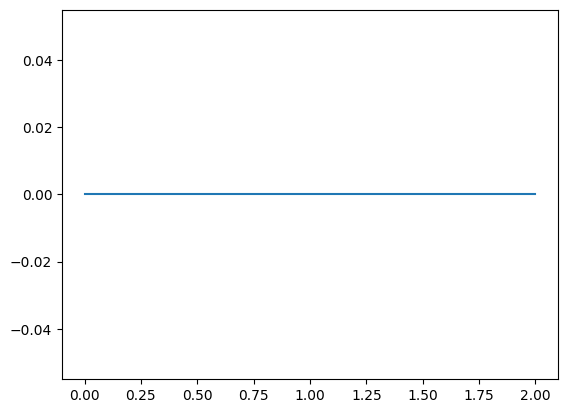

In [13]:
import matplotlib.pyplot as plt

plt.plot(loss_all)
# plt.plot(loss_valid_all)

In [14]:
from torch_geometric.explain.metric import groundtruth_metrics
from sklearn.metrics import confusion_matrix
import numpy as np

def compute_cm(orig_labels, pred_labels, positive_label, negative_label):
    tp = ((orig_labels == pred_labels) & (orig_labels == positive_label)).sum()
    tn = ((orig_labels == pred_labels) & (orig_labels == negative_label)).sum()
    fn = ((orig_labels != pred_labels) & (orig_labels == positive_label)).sum()
    fp = ((orig_labels != pred_labels) & (orig_labels == negative_label)).sum()

    return torch.as_tensor([[tp, fn], [fp, tn]])

def compute_accuracy(cm: torch.Tensor):
    return (cm.diagonal().sum() / cm.sum()).item() if cm.sum().item() != 0 else 0

def compute_precision(cm):
    score = (cm[0,0] / cm[:,0].sum()) 
    return score.item() if not torch.isnan(score) else 0

def compute_recall(cm):
    score = (cm[0,0] / cm[0,:].sum()) 
    return score.item() if not torch.isnan(score) else 0

def compute_f1(cm, precision=None, recall=None):
    if not (precision and recall):
        precision = compute_precision(cm)
        recall = compute_precision(cm)

    return (2*precision*recall)/(precision+recall) if precision + recall > 0 else 0

def compute_metrics(cm):
    metrics = [compute_accuracy, compute_precision, compute_recall, compute_f1]
    results = {}
    for metric in metrics:
        results[metric.__name__.split("_")[-1]] = metric(cm)

    return results

avg_scores = []
model.eval()

acc = []
metrics = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": [],
    "auroc": [],
}
positive_label = 1
negative_label = 0
cm_total = torch.zeros((2,2))
cm_total_sk = np.zeros((2,2))


for batch in tqdm(test_batches):
    pred = model(batch.x, batch.edge_index)

    pred_labels = pred.argmax(dim=1)
    orig_labels = batch.y
    cm = compute_cm(orig_labels, pred_labels, positive_label=positive_label, negative_label=negative_label)

    results = compute_metrics(cm)
    cm_total += cm

    for metric, score in results.items():
        metrics[metric] += [score]

    acc += [(orig_labels == pred_labels).sum()/orig_labels.shape[0]]

    scores = groundtruth_metrics(
        pred_mask=pred[batch.train_mask].max(dim=1)[1],
        target_mask=batch.y[batch.train_mask],
        threshold=0.5,
        metrics=["accuracy", "precision", "recall", "f1_score"]
    )
    avg_scores += [scores]

print("Confusion Matrix", cm_total.tolist())
for metric, scores in metrics.items():
    print(f"{metric.title()}={torch.mean(torch.as_tensor(scores, dtype=torch.float32))}")
import numpy as np
# print(np.mean(acc))

# np.asarray(avg_scores).mean(axis=0)

100%|██████████| 90/90 [00:01<00:00, 67.31it/s]

Confusion Matrix [[1108.0, 5728.0], [2795.0, 51659.0]]
Accuracy=0.7957683205604553
Precision=0.30939480662345886
Recall=0.19766461849212646
F1=0.30939480662345886
Auroc=nan


In [ ]:
########## METRICS LIBRARY
# accuracy | precision | recall | F1

###### PURE 1-LAYER SAGE
# array([0.70954861, 0.70012975, 0.74131944, 0.71829656])

###### PURE 1-LAYER GAT
# array([0.53819444, 0.52934275, 0.71319444, 0.60629397])

##### SAGE-ATTN
# array([0.503125  , 0.50161935, 0.98715278, 0.66517364])

###### PURE 1-LAYER GCN
# array([0.6640625 , 0.63122737, 0.80381944, 0.70562114])


In [71]:
##### PURE 1-LAYER SAGECONV
# Confusion Matrix [[6281.0, 555.0], [47872.0, 6582.0]]
# Accuracy=0.26841437816619873
# Precision=0.18005317449569702
# Recall=0.9099577069282532
# F1=0.18005317449569702
# Auroc=nan

##### PURE 1-LAYER GAT
# Confusion Matrix [[6047.0, 789.0], [34203.0, 20251.0]]
# Accuracy=0.4496999979019165
# Precision=0.21606987714767456
# Recall=0.884824812412262
# F1=0.21606987714767456
# Auroc=nan

##### SAGE-ATTN
# Confusion Matrix [[1196.0, 5640.0], [18660.0, 35794.0]]
# Accuracy=0.5885034203529358
# Precision=0.12076546251773834
# Recall=0.19161765277385712
# F1=0.12076546251773834
# Auroc=nan

###### PURE 1-LAYER GCN
# Confusion Matrix [[5111.0, 1725.0], [17802.0, 36652.0]]
# Accuracy=0.6739125847816467
# Precision=0.29481324553489685
# Recall=0.7564181685447693
# F1=0.29481324553489685
# Auroc=nan
